In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandana as pdna
import geopandas as gpd
import pandas as pd
import osmnx as ox
import math
import networkx as nx
import sys
import matplotlib.pyplot as plt
# adding functions 
sys.path.insert(0, 'C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Walkability\\Other Cities\\Open-Walk-Index')
from walkability_functions import *

Choose a projected CRS to be used for all distance calculations.

In [7]:
folder = "C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\"
proj_crs = "EPSG:2154"

place = 'Malta, Northern Region, Malta'
# Using just 'Malta' gives all islands which doesn't work as the network is not contiguous
place_gdf = ox.geocode_to_gdf(place).to_crs(proj_crs)

C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\geopandas\plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:>

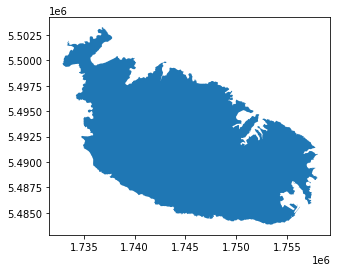

In [8]:
# check that we have the right area. 
place_gdf.geometry.plot()

## Import Data

Data sources:
1. OSM POIs
5. Employment data - find govt source

In [5]:
poi_dictionary = {
    'employment':{
        'category':['employment']
    },
    'shopping':{
        'shop':['bakery', 'clothes', 'supermarket', 'mall', 'greengrocer',
                'seafood', 'wine', 'butcher','convenience',
                'beverages', 'alcohol', 'bicycle_shop', 'department_store', 
                'doityourself', 'beauty_shop', 'outdoor_shop', 
                'stationery', 'bookshop', 'gift_shop', 'newsagent', 
                'car_dealership', 'furniture_shop', 'sports_shop',
                'garden_centre', 'computer_shop', 'shoe_shop', 'florist', 
                'video_shop', 'toy_shop', 'mobile_phone_shop', 'jeweller'],
        # possibly we could pick up all shop=True excluding a few. but not sure how
        # and many options to exclude
        'amenity':['marketplace'],
        'building':['kiosk', 'supermarket',],
    },
    'errands':{
        'amenity':['atm','bank','courthouse','post_box', 'post_office',
                   'clinic', 'dentist', 'doctors', 'hospital',
                   'pharmacy', 'veterinary', 'travel_agent',
                   'place_of_worship'],
        'shop':['optician', 'hairdresser', 'laundry',],
        'healthcare':['physiotherapist'],
        'office':['government'], #### further refine ?
    },
    'recreation':{
        'leisure':['dog_park', 'ice_rink', 'park', 'pitch', 'playground',
                   "fitness_centre","sports_centre", 'stadium', 'swimming_pool',
                   'swimming_area', 'track', 'water_park','golf_course',],
        'club':['social'],
        'amenity':['bar', 'biergarten', 'cafe', 'fast_food', 'food_court',
                   'ice_cream', 'pub', 'restaurant', 'nightclub',
                   'library', 'arts_centre', 'cinema', 'community_centre',
                   'social_centre', 'theatre',],
        'building':['stadium', 'castle', 'ruins',],
        'tourism':['aquarium', 'artwork', 'attraction', 'gallery',
                   'museum', 'picnic_site', 'theme_park', 'viewpoint',
                   'zoo'],
        'natural':['beach'],
    },
    'education':{
        'amenity':['college', 'kindergarten', 'music_school',
                   'school', 'university', 'childcare'],
    }
}

In [6]:
osm_pois = poi_downloader(place_gdf, poi_dictionary, proj_crs)

C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\osmnx\geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\osmnx\geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


Currently, I don't know of a source on employment concentrations in Malta.

In [ ]:
employment_centrs = gpd.read_file((folder + 
                        "")).to_crs(proj_crs)

employment_centrs['category'] = 'employment'
employment_centrs['geometry'] = employment_centrs.geometry.centroid

In [ ]:
employment_centrs

Need to remove potential overlap between different data sources (and inside some data sources). For now I'm not worrying about this when using only OSM data. Then take this combined POI set and clip it to the study area: should be the same area as is covered by the network. This is important otherwise points outside the network may be erroneously linked to the network.

In [ ]:
pois = pd.concat([osm_pois, employment_centrs])

pois = gpd.clip(pois, place_gdf.to_crs(proj_crs))

### Categorise and weight POIs

Choose walk index weightings, and output the sums of each category and the total to check. The walk index will be out of 100 regardless of this sum, but it is important to note that eg. shopping is only '10% of the walk index' if shopping is 10 out of 100.

In [ ]:
poi_parameters = pd.read_csv((folder + 
                              "Walkability\\Other Cities\\Colouring data & results\\Shared Aus Data\\poi_parameters_5.csv"),
                            index_col=0)

In [ ]:
poi_weights = poi_parameters['weight'].copy()

poi_lambdas = poi_parameters['diminishing_returns_constant'].copy()

poi_variables = poi_parameters['variable'].copy()

poi_nums = poi_parameters['num_pois'].copy()

poi_gammas = poi_parameters['distance_constant'].copy()

In [ ]:
total = sum(poi_weights)
print("total: ", total)

In [ ]:
# change this to match the column containting job counts in your employment dataframe
poi_variables.loc['employment'] = 'NB_TOTAL_E'
# change this to make employment score more accurate (higher number) or to reduce index calculation time (low number)
poi_nums.loc['employment'] = 1200

### Import network

Pandana expects edges to have a two item index based on the same IDs as the node index. (with thanks to https://github.com/shriv/accessibility-series/blob/master/Accounting%20for%20hills%20in%20accessibility%20analyses.ipynb)

In [ ]:
#G = ox.graph_from_place(place, network_type='walk')
G = ox.graph.graph_from_polygon(place_gdf.to_crs('EPSG:4326').geometry[0], network_type='walk')

In [ ]:
# Get nodes and edges as geodataframes (gdfs) from OSMNX network
graph_df = ox.graph_to_gdfs(G)
nodes_gdfs = graph_df[0]
edges_gdfs = graph_df[1]

In [ ]:
edges_gdfs = edges_gdfs.to_crs(proj_crs)
nodes_gdfs = nodes_gdfs.to_crs(proj_crs)

## Pandana network creation.

In [ ]:
# with new OSMnx graph from polygon seems to be different
edges_gdfs = edges_gdfs.reset_index()
# Setting indices of Edges gdfs to match expected dataframe for Pandana
edges_gdfs['from_idx'] = edges_gdfs['u']
edges_gdfs['to_idx'] = edges_gdfs['v']
edges_gdfs= edges_gdfs.set_index(['from_idx', 'to_idx'])
edges_gdfs.index.names= ['','']

# Setting indices of Nodes gdfs to match expected dataframe for Pandana
nodes_gdfs.index.name = 'id'
# Create a pandana network with data extracted from an OSMNX graph
distance_network = pdna.Network(nodes_gdfs.geometry.x, nodes_gdfs.geometry.y,
                                   edges_gdfs['u'], edges_gdfs['v'], 
                                   edges_gdfs[['length']])

### Pandana network querying. 

In [ ]:
maximum_dist=2400

In [ ]:
results_walk = there_index(distance_network, pois, poi_dictionary, poi_weights, poi_gammas,
                            poi_nums, poi_lambdas, poi_variables, distance=maximum_dist)

In [ ]:
max(results_walk['THERE_Index']), np.mean(results_walk['THERE_Index'])

The current approach is to find up to x closest nodes for each category within the maximum distance. Then look up the attractiveness at each one (just count for most), apply a distance decay function to each distance, apply diminishing returns to the resulting total opportunity, and sum.

An alternative approach which would be more convenient would be to use the Pandana 'aggregate' function which aggregates from all nodes within the maximum distance including applying a decay function. However, there is limited ability to change the distance decay rate within the aggregation function. It can either be flat (no decay), linear (going to 0 at the max distance), or exponential where beta is set as 1/max distance. For walking I would like a beta of 0.001, but this requires the radius to be 1000m. If the radius is 2400m, beta is only 0.0004. This can be changed in the future if the Pandana function is updated to take a decay parameter.

## Export results

Reduce the number of decimal places before export, distances do not need to be below 1m.

In [ ]:
def result_rounding(results):
    # reduces results size for export
    # score columns such as THERE_Index, employment_subtotal etc -> 3 decimal places
    # distance columns such as employment1 -> 0 decimal places (nearest metre)
    # avoid doing anything to connect_id, x or y
    rounding_dict = {**{k:3 for k in results.columns if "Index" in k or "." in k
                        and 'connect_id' not in k},
                     **{k:0 for k in results.columns if "Index" not in k and "." not in k
                        and k != 'x'
                        and k != 'y'}}
    return results.round(rounding_dict)

In [ ]:
small_w_results = gpd.GeoDataFrame(result_rounding(results_walk), geometry = gpd.GeoSeries.from_xy(results_walk.x, results_walk.y, crs=proj_crs))

 ### Population weighted results

Import smallest statistical unit for which population data is available (meshblocks in Australia). Join this to the results (by population weighted centroid location if available, otherwise geometric centroid location). Then results can be graphed or visualised by population, giving a more accurate picture of the population access by walking.

In [ ]:
blocks = gpd.read_file(folder + "Data\\Paris\\IRIS Mainland\\CONTOURS-IRIS.shp").to_crs(proj_crs)

In [ ]:
paris_blocks = blocks.clip(place_gdf)

In [ ]:
population = pd.read_csv(folder + "Data\\Paris\\FD_INDCVIZA_2015.txt",sep=";")
#population = population.set_index('MB_CODE_2016')

This census data represents about 35% of the total population in the Ile-de-France.

In [ ]:
IRIS = population.loc[:,['IRAN','IRIS']].groupby('IRIS').count()/0.35

In [ ]:
IRIS.sum()

In [ ]:
paris_blocks['IRIS'] = paris_blocks['IRIS'].astype('int64')
paris_blocks.geometry = paris_blocks.centroid

In [ ]:
join_blocks = paris_blocks.join(IRIS, on='CODE_IRIS', how='left', rsuffix='pop')

In [ ]:
np.nansum(join_blocks.IRAN)

In [ ]:
join_blocks = join_blocks.to_crs(proj_crs)

In [ ]:
small_w_results = small_w_results.to_crs(proj_crs)

In [ ]:
join_blocks = join_blocks.sjoin_nearest(small_w_results, how='left', rsuffix = 'walk')

Population weighted average THERE index:

In [ ]:
np.nansum(join_blocks['IRAN']*join_blocks['THERE_Index'])/np.nansum(join_blocks['IRAN'])

In [ ]:
join_blocks = join_blocks[join_blocks['IRAN'] > 0]

In [ ]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(12, 4))
#f.set_figwidth(4)
bins=[10,20,30,40,50,60,70,80,90,100]
ax1.hist(join_blocks['THERE_Index'], weights = join_blocks['IRAN'], label='WalkTHERE',bins=bins)
ax1.set_xlabel('WalkTHERE')
ax1.set_ylabel('Residents')

fig.suptitle('Paris: distribution of results by residential population')

And thus we find that something is wrong here... surely this is not possible? Or maybe it is? Need to get the more accurate employment data and look at results in more detail.

### Visualise results

In [ ]:
small_w_results.plot(column="THERE_Index", legend=True,
                     cmap='Greens',figsize=(5,5),markersize=1)

In [ ]:
small_w_results.plot(column="employment_31.9", cmap='Greens',figsize=(20,20),markersize=1)

In [ ]:
small_w_results.to_file((folder + "Walkability\\Other Cities\\Colouring data & results\\Paris results walk 190722.gpkg"))